<a href="https://colab.research.google.com/github/jude1997felix/Decentralized-Air-quality-Monitoring-and-Prediction/blob/main/imputations_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import os
import datetime
import math 
import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf

# Helper Functions

In [2]:
def time_features(df,time):
  df['weekday'] = df[time].dt.day_name()
  weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday']
  weekends = ['Saturday','Sunday']
  df['week'] = 'weekday'
  for i in range(len(df.weekday)):
    #print(df.weekday[i])
    #break
    if df.weekday[i] in weekends:
      df['week'][i] = 'weekend'
  # df.head(30)

  y = pd.get_dummies(df.weekday)
  z = pd.get_dummies(df.week)
  del df['weekday']
  del df['week']
  df = df.join(y)
  df = df.merge(z,left_index=True, right_index=True)
  # df = merge(df)

  df['week'] = df[time].dt.isocalendar().week

  df['month'] = df[time].dt.month_name()
  x = pd.get_dummies(df.month)
  df = df.join(x)
  del df['month']
  return df

# pm10 = time_features(pm10,'Start')

In [3]:
# def compile_and_fit(model, window, patience=2):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#   model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.optimizers.Adam(),
#                 metrics=[tf.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
#   return history



def compile_and_fit(model, window, patience=50, recompile=True):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  if recompile:
      model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[smape])
                # metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
                      # )
  return history

In [4]:
def plot(self, model=None, plot_col='PM10 (107)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')


In [5]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels




In [6]:
MAX_EPOCHS = 20
def models(df):
  # df = df_fillna_b
  for cols in df.columns:
    if cols == 'Slut':
      del df['Slut']
    elif cols == 'Black Carbon (410)':
      del df['Black Carbon (410)']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  x = df.values #returns a numpy array
  sc = StandardScaler()
  x_scaled = sc.fit_transform(x)
  df = pd.DataFrame(x_scaled)

  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]

  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  # train_df = (train_df - train_mean) / train_std
  # val_df = (val_df - train_mean) / train_std
  # test_df = (test_df - train_mean) / train_std

  df_std = (df - train_mean) / train_std
  # df_std = df_std.melt(var_name='Column', value_name='Normalized')
  # plt.figure(figsize=(12, 6))
  # ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
  # _ = ax.set_xticklabels(df.keys(), rotation=90)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example



  single_step_window = WindowGenerator(
      input_width=24, label_width=1, shift=24,
      label_columns=['PM10 (107)'])
  # single_step_window
  
  # Baseline model
  print('Baseline model')
  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
      super().__init__()
      self.label_index = label_index

    def call(self, inputs):
      if self.label_index is None:
        return inputs
      result = inputs[:, :, self.label_index]
      return result[:, :, tf.newaxis]

  baseline = Baseline(label_index=column_indices['PM10 (107)'])

  baseline.compile(loss=tf.losses.MeanSquaredError(),
                  metrics=[smape])

  val_performance = {}
  performance = {}
  val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
  performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,label_columns=['PM10 (107)'])

  # wide_window.plot(baseline)

  # Linear
  # print('Linear model')
  # linear = tf.keras.Sequential([
  #     tf.keras.layers.Dense(units=1)
  # ])

  # MAX_EPOCHS = 20

  # history = compile_and_fit(linear, single_step_window)

  # val_performance['Linear'] = linear.evaluate(single_step_window.val)
  # performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

  # wide_window.plot(linear)

  # Dense model
  # print('Dense model')
  # dense = tf.keras.Sequential([
  #     tf.keras.layers.Dense(units=64, activation='relu'),
  #     tf.keras.layers.Dense(units=64, activation='relu'),
  #     tf.keras.layers.Dense(units=1)
  # ])

  # history = compile_and_fit(dense, single_step_window)

  # val_performance['Dense'] = dense.evaluate(single_step_window.val)
  # performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  # wide_window.plot(dense)

  # Multi Dense model
  print('Multi dense model')

  CONV_WIDTH = 3
  conv_window = WindowGenerator(
      input_width=CONV_WIDTH,
      label_width=1,
      shift=1,
      label_columns=['PM10 (107)'])

  conv_window

  multi_step_dense = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])
  history = compile_and_fit(multi_step_dense, conv_window)

  # IPython.display.clear_output()
  val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
  performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  # wide_window.plot(multi_step_dense)

  # CNN
  # print('CNN model')
  # conv_model = tf.keras.Sequential([
  #     tf.keras.layers.Conv1D(filters=32,
  #                           kernel_size=(CONV_WIDTH,),
  #                           activation='relu'),
  #     tf.keras.layers.Dense(units=32, activation='relu'),
  #     tf.keras.layers.Dense(units=1),
  # ])

  # history = compile_and_fit(conv_model, conv_window)

  # IPython.display.clear_output()
  # val_performance['Conv'] = conv_model.evaluate(conv_window.val)
  # performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  # # LSTM
  print('LSTM model')
  lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])

  history = compile_and_fit(lstm_model, wide_window)

  # IPython.display.clear_output()
  val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
  performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
  # wide_window.plot(lstm_model)  
  x = np.arange(len(performance))
  width = 0.3


  val_smape = [v[1] for v in val_performance.values()]
  test_smape = [v[1] for v in performance.values()]

  plt.bar(x - 0.17, val_smape, width, label='Validation')
  plt.bar(x + 0.17, test_smape, width, label='Test')
  plt.xticks(ticks=x, labels=performance.keys(),
            rotation=45)
  plt.ylabel(f'MAE (average over all times and outputs)')
  _ = plt.legend()# # return (lstm_model, val_performance, performance)
  print('Performance on validation data {}'.format(val_performance))
  print('Performance on test data {}'.format(performance))
# models(df_deleted)


In [7]:
def missing_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    
    for col in df.columns:
        missing = df[col].isnull()
        num_missing = np.sum(missing)

        if num_missing > 0:  
            print('created missing indicator for: {} and the missing values are : {}'.format(col,num_missing))

# Raw data

In [202]:
path = '/content/8780.csv'

In [ ]:
NO2 (115)	NOX as NO2 (114)	O3 (537)	PM10 (116)	PM2.5 (111)

# PM10

In [225]:
df = pd.read_csv(path,sep = ';', skiprows=16,parse_dates=['Start','Slut'])
df['hour'] = df['Start'].dt.hour
# df.dropna(inplace = True)
df.head()

,Start,Slut,Black Carbon (409),Black Carbon (4783),CO (113),NO2 (115),NOX as NO2 (114),O3 (537),PM10 (116),PM2.5 (111),hour
0,2015-01-01 00:00:00,2015-01-01 01:00:00,NaN,NaN,0.32,36.9,101.5,12.5,32.5,15.1,0
1,2015-01-01 01:00:00,2015-01-01 02:00:00,NaN,NaN,0.23,38.6,78.3,22.0,11.0,6.4,1
2,2015-01-01 02:00:00,2015-01-01 03:00:00,NaN,NaN,0.24,26.8,49.6,32.2,13.8,6.2,2
3,2015-01-01 03:00:00,2015-01-01 04:00:00,NaN,NaN,0.18,30.5,65.8,32.3,15.2,6.5,3
4,2015-01-01 04:00:00,2015-01-01 05:00:00,NaN,NaN,0.14,20.9,37.6,36.5,15.3,6.6,4


In [226]:
col = 'PM10 (116)'
df = df.set_index('Start')
pm10 = pd.DataFrame(df[col])
pm10.head()

,PM10 (116)
Start,
2015-01-01 00:00:00,32.5
2015-01-01 01:00:00,11.0
2015-01-01 02:00:00,13.8
2015-01-01 03:00:00,15.2
2015-01-01 04:00:00,15.3


In [227]:
missing_values(pm10)

PM10 (116) - 4.0%
created missing indicator for: PM10 (116) and the missing values are : 1585


In [228]:
pm10 = pm10.reset_index() 
pm10 = time_features(pm10,'Start')
del pm10['week']
pm10.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Start,PM10 (116),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September
0,2015-01-01 00:00:00,32.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2015-01-01 01:00:00,11.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2015-01-01 02:00:00,13.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2015-01-01 03:00:00,15.2,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2015-01-01 04:00:00,15.3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [229]:
pm10.index = range(43824)
# pm10.set_index('index')
pm10.head()

,Start,PM10 (116),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September
0,2015-01-01 00:00:00,32.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2015-01-01 01:00:00,11.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2015-01-01 02:00:00,13.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2015-01-01 03:00:00,15.2,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2015-01-01 04:00:00,15.3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [230]:
negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

69


In [231]:
pm10[col] = pm10[col].apply(lambda x: abs(x*0) if x<0 else x)

negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

0


In [232]:
missing = pm10[col].isnull()
missing_index = []
for idx,value in enumerate(missing):
  if value == True:
    missing_index.append(idx)
  
print(missing_index)

[322, 323, 706, 707, 709, 875, 876, 948, 949, 950, 951, 952, 1114, 1115, 1116, 2090, 2121, 3169, 3376, 3535, 3536, 3789, 4842, 5317, 5318, 5822, 5823, 5824, 6179, 6573, 6583, 6584, 6609, 6725, 6726, 6757, 6758, 6759, 7016, 8505, 8506, 8529, 8530, 8759, 9852, 9853, 9854, 10694, 10695, 10826, 10885, 11098, 11099, 11290, 11605, 11626, 11906, 11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11921, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12441, 12442, 12443, 12444, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12844, 12845, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 13178, 13196, 13452, 13453, 14877, 14973, 14974, 14975, 15011, 15305, 15306, 15307, 15308, 15309, 15393, 15394, 15395, 15396, 15397, 15398, 15399, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 1

In [233]:
pm10['seconds'] = pm10['Start'].map(datetime.datetime.timestamp)

In [234]:
day = 24*60*60
year = (365.2425)*day

pm10['Day sin'] = np.sin(pm10['seconds'] * (2 * np.pi / day))
pm10['Day cos'] = np.cos(pm10['seconds'] * (2 * np.pi / day))
pm10['Year sin'] = np.sin(pm10['seconds'] * (2 * np.pi / year))
pm10['Year cos'] = np.cos(pm10['seconds'] * (2 * np.pi / year))

In [235]:
del pm10['Start']
del pm10['seconds']
pm10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PM10 (116)  42239 non-null  float64
 1   Friday      43824 non-null  uint8  
 2   Monday      43824 non-null  uint8  
 3   Saturday    43824 non-null  uint8  
 4   Sunday      43824 non-null  uint8  
 5   Thursday    43824 non-null  uint8  
 6   Tuesday     43824 non-null  uint8  
 7   Wednesday   43824 non-null  uint8  
 8   weekday     43824 non-null  uint8  
 9   weekend     43824 non-null  uint8  
 10  April       43824 non-null  uint8  
 11  August      43824 non-null  uint8  
 12  December    43824 non-null  uint8  
 13  February    43824 non-null  uint8  
 14  January     43824 non-null  uint8  
 15  July        43824 non-null  uint8  
 16  June        43824 non-null  uint8  
 17  March       43824 non-null  uint8  
 18  May         43824 non-null  uint8  
 19  November    43824 non-nul

In [236]:
pm10_test = pm10.iloc[missing_index]
pm10_test.head()

,PM10 (116),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September,Day sin,Day cos,Year sin,Year cos
322,NaN,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.500000,-0.866025,0.230225,0.973137
323,NaN,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.258819,-0.965926,0.230923,0.972972
706,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.500000,-0.866025,0.486041,0.873936
707,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.258819,-0.965926,0.486667,0.873588
709,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.258819,-0.965926,0.487919,0.872889


In [237]:
df = pm10.copy()
df.head()

,PM10 (116),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September,Day sin,Day cos,Year sin,Year cos
0,32.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.232357e-12,1.000000,0.001505,0.999999
1,11.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2.588190e-01,0.965926,0.002222,0.999998
2,13.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,5.000000e-01,0.866025,0.002939,0.999996
3,15.2,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,7.071068e-01,0.707107,0.003656,0.999993
4,15.3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,8.660254e-01,0.500000,0.004372,0.999990


In [238]:
df.dropna(inplace=True)

### Model

In [239]:
  # del df['Start']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  # x = df.values #returns a numpy array
  sc = MinMaxScaler()
  # x_scaled = sc.fit_transform(x)
  # df = pd.DataFrame(x_scaled)

  y = pm10_test.values
  y_scaled = sc.fit_transform(y)
  # pm10_test = 
  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  x = train_df.values
  train_scaled = sc.fit_transform(x)
  train_df = pd.DataFrame(train_scaled,columns=cols)
  val_df = df[int(n*0.70):int(n*0.85)]
  x = val_df.values
  train_scaled = sc.fit_transform(x)
  val_df = pd.DataFrame(train_scaled,columns=cols)
  # test_df = pd.DataFrame(y_scaled)
  test_df = df[int(n*0.85):]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)


  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  df_std = (df - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [240]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

      # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
      # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
      # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

  

single_step_window = WindowGenerator(
      input_width=2, label_width=1, shift=1,
      label_columns=[col])
  # single_step_window
print(single_step_window.test)


<MapDataset shapes: ((None, 2, 26), (None, 1, 1)), types: (tf.float32, tf.float32)>


In [241]:
  model = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=50,
                                                    mode='min')

  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  
  model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[smape])
                # metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(single_step_window.train, epochs=MAX_EPOCHS,
                      validation_data=single_step_window.val,
                      callbacks=[early_stopping])


  # history,model = compile_and_fit(multi_step_dense, single_step_window)
  # val_performance = []
  # performance = []
  # IPython.display.clear_output()
  val_performance = model.evaluate(single_step_window.val)
  performance = model.evaluate(single_step_window.test, verbose=0)
  # predicted_values = model.predict(single_step_window.test)

Epoch 1/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0034 - smape: 0.4947 - val_loss: 0.0012 - val_smape: 0.4990
Epoch 2/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0017 - smape: 0.3730 - val_loss: 0.0014 - val_smape: 0.5498
Epoch 3/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0016 - smape: 0.3473 - val_loss: 9.5223e-04 - val_smape: 0.4581
Epoch 4/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0015 - smape: 0.3374 - val_loss: 0.0011 - val_smape: 0.5014
Epoch 5/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0014 - smape: 0.3203 - val_loss: 9.5521e-04 - val_smape: 0.4228
Epoch 6/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0014 - smape: 0.3208 - val_loss: 8.7429e-04 - val_smape: 0.4255
Epoch 7/20
924/924 [==============================] - 4s 4ms/step - loss: 0.0014 - smape: 0.3110 - val_loss: 9.3390e-04 - val_smape: 0.4791
Epoch 8/20
924/924 [============

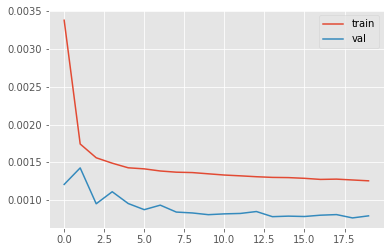

In [242]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [243]:
for idx in missing_index:
  test_df = pm10.iloc[idx-2:idx+1]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                  train_df=train_df, val_df=val_df, test_df=test_df,
                  label_columns=None):
        # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

        # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}

        # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
        # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example

    

  single_step_window = WindowGenerator(
        input_width=2, label_width=1, shift=1,
        label_columns=[col])

  predict = model.predict(single_step_window.test)
  test_df[col][2] = predict

  test_df = sc.inverse_transform(test_df)
  test_df = pd.DataFrame(test_df,columns=df.columns)
  # test_df.head()

  pm10[col][idx] = test_df[col].iloc[2]

Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [244]:
missing_values(pm10)

PM10 (116) - 0.0%
Friday - 0.0%
Monday - 0.0%
Saturday - 0.0%
Sunday - 0.0%
Thursday - 0.0%
Tuesday - 0.0%
Wednesday - 0.0%
weekday - 0.0%
weekend - 0.0%
April - 0.0%
August - 0.0%
December - 0.0%
February - 0.0%
January - 0.0%
July - 0.0%
June - 0.0%
March - 0.0%
May - 0.0%
November - 0.0%
October - 0.0%
September - 0.0%
Day sin - 0.0%
Day cos - 0.0%
Year sin - 0.0%
Year cos - 0.0%


In [245]:
pm10_imp = pm10.copy()

# NO2

In [246]:
df = pd.read_csv(path,sep = ';', skiprows=16,parse_dates=['Start','Slut'])
# df['hour'] = df['Start'].dt.hour
# df.dropna(inplace = True)
df.head()

,Start,Slut,Black Carbon (409),Black Carbon (4783),CO (113),NO2 (115),NOX as NO2 (114),O3 (537),PM10 (116),PM2.5 (111)
0,2015-01-01 00:00:00,2015-01-01 01:00:00,NaN,NaN,0.32,36.9,101.5,12.5,32.5,15.1
1,2015-01-01 01:00:00,2015-01-01 02:00:00,NaN,NaN,0.23,38.6,78.3,22.0,11.0,6.4
2,2015-01-01 02:00:00,2015-01-01 03:00:00,NaN,NaN,0.24,26.8,49.6,32.2,13.8,6.2
3,2015-01-01 03:00:00,2015-01-01 04:00:00,NaN,NaN,0.18,30.5,65.8,32.3,15.2,6.5
4,2015-01-01 04:00:00,2015-01-01 05:00:00,NaN,NaN,0.14,20.9,37.6,36.5,15.3,6.6


In [247]:
col = 'NO2 (115)'
df = df.set_index('Start')
pm10 = pd.DataFrame(df[col])
pm10.head()

,NO2 (115)
Start,
2015-01-01 00:00:00,36.9
2015-01-01 01:00:00,38.6
2015-01-01 02:00:00,26.8
2015-01-01 03:00:00,30.5
2015-01-01 04:00:00,20.9


In [248]:
missing_values(pm10)

NO2 (115) - 1.0%
created missing indicator for: NO2 (115) and the missing values are : 403


In [249]:
pm10 = pm10.reset_index() 
pm10 = time_features(pm10,'Start')
del pm10['week']
pm10.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Start,NO2 (115),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September
0,2015-01-01 00:00:00,36.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2015-01-01 01:00:00,38.6,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2015-01-01 02:00:00,26.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2015-01-01 03:00:00,30.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2015-01-01 04:00:00,20.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [250]:
idxs = len(pm10) 
pm10.index = range(idxs)
# pm10.set_index('index')
pm10.head()

,Start,NO2 (115),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September
0,2015-01-01 00:00:00,36.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2015-01-01 01:00:00,38.6,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2015-01-01 02:00:00,26.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2015-01-01 03:00:00,30.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2015-01-01 04:00:00,20.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [251]:
negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

0


In [252]:
missing = pm10[col].isnull()
missing_index = []
for idx,value in enumerate(missing):
  if value == True:
    missing_index.append(idx)
  
print(missing_index)

[529, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 1452, 2003, 2090, 2966, 2967, 3171, 3347, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 4046, 4302, 4869, 5569, 5606, 5636, 5995, 6033, 6734, 7594, 8234, 8569, 8759, 8991, 9419, 9470, 10547, 10569, 10826, 11067, 11076, 11223, 11225, 11275, 11606, 11671, 11980, 12251, 12436, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510, 12511, 12512, 12513, 12514, 12515, 12516, 12517, 12534, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12964, 13223, 13840, 14236, 14871, 15239, 15359, 15640, 15821, 15915, 15978, 16222, 16269, 16919, 17483, 17543, 17647, 17658

In [253]:
pm10['seconds'] = pm10['Start'].map(datetime.datetime.timestamp)

In [254]:
day = 24*60*60
year = (365.2425)*day

pm10['Day sin'] = np.sin(pm10['seconds'] * (2 * np.pi / day))
pm10['Day cos'] = np.cos(pm10['seconds'] * (2 * np.pi / day))
pm10['Year sin'] = np.sin(pm10['seconds'] * (2 * np.pi / year))
pm10['Year cos'] = np.cos(pm10['seconds'] * (2 * np.pi / year))

In [255]:
del pm10['Start']
del pm10['seconds']
pm10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NO2 (115)  43421 non-null  float64
 1   Friday     43824 non-null  uint8  
 2   Monday     43824 non-null  uint8  
 3   Saturday   43824 non-null  uint8  
 4   Sunday     43824 non-null  uint8  
 5   Thursday   43824 non-null  uint8  
 6   Tuesday    43824 non-null  uint8  
 7   Wednesday  43824 non-null  uint8  
 8   weekday    43824 non-null  uint8  
 9   weekend    43824 non-null  uint8  
 10  April      43824 non-null  uint8  
 11  August     43824 non-null  uint8  
 12  December   43824 non-null  uint8  
 13  February   43824 non-null  uint8  
 14  January    43824 non-null  uint8  
 15  July       43824 non-null  uint8  
 16  June       43824 non-null  uint8  
 17  March      43824 non-null  uint8  
 18  May        43824 non-null  uint8  
 19  November   43824 non-null  uint8  
 20  Octobe

In [256]:
pm10_test = pm10.iloc[missing_index]
pm10_test.head()

,NO2 (115),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September,Day sin,Day cos,Year sin,Year cos
529,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.258819,9.659258e-01,0.371555,0.928411
555,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.707107,7.071068e-01,0.388791,0.921326
556,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.866025,5.000000e-01,0.389452,0.921047
557,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.965926,2.588190e-01,0.390112,0.920767
558,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1.000000,4.328005e-12,0.390772,0.920488


In [257]:
df = pm10.copy()
df.head()

,NO2 (115),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday,weekend,April,August,December,February,January,July,June,March,May,November,October,September,Day sin,Day cos,Year sin,Year cos
0,36.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.232357e-12,1.000000,0.001505,0.999999
1,38.6,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2.588190e-01,0.965926,0.002222,0.999998
2,26.8,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,5.000000e-01,0.866025,0.002939,0.999996
3,30.5,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,7.071068e-01,0.707107,0.003656,0.999993
4,20.9,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,8.660254e-01,0.500000,0.004372,0.999990


In [258]:
df.dropna(inplace=True)

### Model

In [259]:
  # del df['Start']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  # x = df.values #returns a numpy array
  sc = MinMaxScaler()
  # x_scaled = sc.fit_transform(x)
  # df = pd.DataFrame(x_scaled)

  y = pm10_test.values
  y_scaled = sc.fit_transform(y)
  # pm10_test = 
  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  x = train_df.values
  train_scaled = sc.fit_transform(x)
  train_df = pd.DataFrame(train_scaled,columns=cols)
  val_df = df[int(n*0.70):int(n*0.85)]
  x = val_df.values
  train_scaled = sc.fit_transform(x)
  val_df = pd.DataFrame(train_scaled,columns=cols)
  # test_df = pd.DataFrame(y_scaled)
  test_df = df[int(n*0.85):]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)


  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  df_std = (df - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [260]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

      # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
      # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
      # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

  

single_step_window = WindowGenerator(
      input_width=2, label_width=1, shift=1,
      label_columns=[col])
  # single_step_window
print(single_step_window.test)


<MapDataset shapes: ((None, 2, 26), (None, 1, 1)), types: (tf.float32, tf.float32)>


In [ ]:
  model = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  
  model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[smape])
                # metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(single_step_window.train, epochs=MAX_EPOCHS,
                      validation_data=single_step_window.val,
                      callbacks=[early_stopping])


  # history,model = compile_and_fit(multi_step_dense, single_step_window)
  # val_performance = []
  # performance = []
  # IPython.display.clear_output()
  val_performance = model.evaluate(single_step_window.val)
  performance = model.evaluate(single_step_window.test, verbose=0)
  # predicted_values = model.predict(single_step_window.test)

Epoch 1/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0073 - smape: 0.3759 - val_loss: 0.0085 - val_smape: 0.3595
Epoch 2/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0047 - smape: 0.3149 - val_loss: 0.0077 - val_smape: 0.3285
Epoch 3/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0044 - smape: 0.3023 - val_loss: 0.0074 - val_smape: 0.3179
Epoch 4/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0042 - smape: 0.2980 - val_loss: 0.0073 - val_smape: 0.3170
Epoch 5/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0041 - smape: 0.2917 - val_loss: 0.0072 - val_smape: 0.3211
Epoch 6/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0040 - smape: 0.2891 - val_loss: 0.0073 - val_smape: 0.3292
Epoch 7/20
950/950 [==============================] - 4s 4ms/step - loss: 0.0039 - smape: 0.2844 - val_loss: 0.0072 - val_smape: 0.3364
Epoch 8/20
950/950 [============================

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
for idx in missing_index:
  test_df = pm10.iloc[idx-2:idx+1]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                  train_df=train_df, val_df=val_df, test_df=test_df,
                  label_columns=None):
        # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

        # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}

        # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
        # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example

    

  single_step_window = WindowGenerator(
        input_width=2, label_width=1, shift=1,
        label_columns=[col])

  predict = model.predict(single_step_window.test)
  test_df[col][2] = predict

  test_df = sc.inverse_transform(test_df)
  test_df = pd.DataFrame(test_df,columns=df.columns)
  # test_df.head()

  pm10[col][idx] = test_df[col].iloc[2]

In [ ]:
missing_values(pm10)

In [ ]:
no2_imp = pm10.copy()

# NOX

In [ ]:
df = pd.read_csv(path,sep = ';', skiprows=16,parse_dates=['Start','Slut'])
df['hour'] = df['Start'].dt.hour
# df.dropna(inplace = True)
df.head()

In [ ]:
col = 'NOX as NO2 (114)'
df = df.set_index('Start')
pm10 = pd.DataFrame(df[col])
pm10.head()

In [ ]:
missing_values(pm10)

In [ ]:
pm10 = pm10.reset_index() 
pm10 = time_features(pm10,'Start')
del pm10['week']
pm10.head()

In [ ]:
idxs = len(pm10) 
pm10.index = range(idxs)
# pm10.set_index('index')
pm10.head()

In [ ]:
negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

In [ ]:
missing = pm10[col].isnull()
missing_index = []
for idx,value in enumerate(missing):
  if value == True:
    missing_index.append(idx)
  
print(missing_index)

In [ ]:
pm10['seconds'] = pm10['Start'].map(datetime.datetime.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

pm10['Day sin'] = np.sin(pm10['seconds'] * (2 * np.pi / day))
pm10['Day cos'] = np.cos(pm10['seconds'] * (2 * np.pi / day))
pm10['Year sin'] = np.sin(pm10['seconds'] * (2 * np.pi / year))
pm10['Year cos'] = np.cos(pm10['seconds'] * (2 * np.pi / year))

In [ ]:
del pm10['Start']
del pm10['seconds']
pm10.info()

In [ ]:
pm10_test = pm10.iloc[missing_index]
pm10_test.head()

In [ ]:
df = pm10.copy()
df.head()

In [ ]:
df.dropna(inplace=True)

### Model

In [ ]:
  # del df['Start']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  # x = df.values #returns a numpy array
  sc = MinMaxScaler()
  # x_scaled = sc.fit_transform(x)
  # df = pd.DataFrame(x_scaled)

  y = pm10_test.values
  y_scaled = sc.fit_transform(y)
  # pm10_test = 
  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  x = train_df.values
  train_scaled = sc.fit_transform(x)
  train_df = pd.DataFrame(train_scaled,columns=cols)
  val_df = df[int(n*0.70):int(n*0.85)]
  x = val_df.values
  train_scaled = sc.fit_transform(x)
  val_df = pd.DataFrame(train_scaled,columns=cols)
  # test_df = pd.DataFrame(y_scaled)
  test_df = df[int(n*0.85):]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)


  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  df_std = (df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

      # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
      # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
      # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

  

single_step_window = WindowGenerator(
      input_width=2, label_width=1, shift=1,
      label_columns=[col])
  # single_step_window
print(single_step_window.test)


In [ ]:
  model = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  
  model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[smape])
                # metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(single_step_window.train, epochs=MAX_EPOCHS,
                      validation_data=single_step_window.val,
                      callbacks=[early_stopping])


  # history,model = compile_and_fit(multi_step_dense, single_step_window)
  # val_performance = []
  # performance = []
  # IPython.display.clear_output()
  val_performance = model.evaluate(single_step_window.val)
  performance = model.evaluate(single_step_window.test, verbose=0)
  # predicted_values = model.predict(single_step_window.test)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
for idx in missing_index:
  test_df = pm10.iloc[idx-2:idx+1]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                  train_df=train_df, val_df=val_df, test_df=test_df,
                  label_columns=None):
        # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

        # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}

        # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
        # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example

    

  single_step_window = WindowGenerator(
        input_width=2, label_width=1, shift=1,
        label_columns=[col])

  predict = model.predict(single_step_window.test)
  test_df[col][2] = predict

  test_df = sc.inverse_transform(test_df)
  test_df = pd.DataFrame(test_df,columns=df.columns)
  # test_df.head()

  pm10[col][idx] = test_df[col].iloc[2]

In [ ]:
missing_values(pm10)

In [ ]:
nox_imp = pm10.copy()

# PM2.5

In [ ]:
df = pd.read_csv(path,sep = ';', skiprows=16,parse_dates=['Start','Slut'])
df['hour'] = df['Start'].dt.hour
# df.dropna(inplace = True)
df.head()

In [ ]:
col = 'PM2.5 (111)'
df = df.set_index('Start')
pm10 = pd.DataFrame(df[col])
pm10.head()

In [ ]:
missing_values(pm10)

In [ ]:
pm10 = pm10.reset_index() 
pm10 = time_features(pm10,'Start')
del pm10['week']
pm10.head()

In [ ]:
idxs = len(pm10) 
pm10.index = range(idxs)
# pm10.set_index('index')
pm10.head()

In [ ]:
negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

In [ ]:
pm10[col] = pm10[col].apply(lambda x: abs(x*0) if x<0 else x)

negative_index = []
for idx,val in enumerate(pm10[col]):
  if val < 0:
    negative_index.append(idx)

print(len(negative_index))

In [ ]:
missing = pm10[col].isnull()
missing_index = []
for idx,value in enumerate(missing):
  if value == True:
    missing_index.append(idx)
  
print(missing_index)

In [ ]:
pm10['seconds'] = pm10['Start'].map(datetime.datetime.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

pm10['Day sin'] = np.sin(pm10['seconds'] * (2 * np.pi / day))
pm10['Day cos'] = np.cos(pm10['seconds'] * (2 * np.pi / day))
pm10['Year sin'] = np.sin(pm10['seconds'] * (2 * np.pi / year))
pm10['Year cos'] = np.cos(pm10['seconds'] * (2 * np.pi / year))

In [ ]:
del pm10['Start']
del pm10['seconds']
pm10.info()

In [ ]:
pm10_test = pm10.iloc[missing_index]
pm10_test.head()

In [ ]:
df = pm10.copy()
df.head()

In [ ]:
df.dropna(inplace=True)

### Model

In [ ]:
  # del df['Start']
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)

  cols = df.columns
  # x = df.values #returns a numpy array
  sc = MinMaxScaler()
  # x_scaled = sc.fit_transform(x)
  # df = pd.DataFrame(x_scaled)

  y = pm10_test.values
  y_scaled = sc.fit_transform(y)
  # pm10_test = 
  
  df.columns = cols

  train_df = df[0:int(n*0.7)]
  x = train_df.values
  train_scaled = sc.fit_transform(x)
  train_df = pd.DataFrame(train_scaled,columns=cols)
  val_df = df[int(n*0.70):int(n*0.85)]
  x = val_df.values
  train_scaled = sc.fit_transform(x)
  val_df = pd.DataFrame(train_scaled,columns=cols)
  # test_df = pd.DataFrame(y_scaled)
  test_df = df[int(n*0.85):]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)


  num_features = df.shape[1]
  # return(train_df,val_df,test_df,num_features)
  train_mean = train_df.mean()
  train_std = train_df.std()

  df_std = (df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

      # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
      # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
      # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

  

single_step_window = WindowGenerator(
      input_width=2, label_width=1, shift=1,
      label_columns=[col])
  # single_step_window
print(single_step_window.test)


In [ ]:
  model = tf.keras.Sequential([
      # Shape: (time, features) => (time*features)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1),
      # Add back the time dimension.
      # Shape: (outputs) => (1, outputs)
      tf.keras.layers.Reshape([1, -1]),
  ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

  def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                          / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

  
  model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[smape])
                # metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(single_step_window.train, epochs=MAX_EPOCHS,
                      validation_data=single_step_window.val,
                      callbacks=[early_stopping])


  # history,model = compile_and_fit(multi_step_dense, single_step_window)
  # val_performance = []
  # performance = []
  # IPython.display.clear_output()
  val_performance = model.evaluate(single_step_window.val)
  performance = model.evaluate(single_step_window.test, verbose=0)
  # predicted_values = model.predict(single_step_window.test)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
for idx in missing_index:
  test_df = pm10.iloc[idx-2:idx+1]
  x = test_df.values
  train_scaled = sc.fit_transform(x)
  test_df = pd.DataFrame(train_scaled,columns=cols)

  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                  train_df=train_df, val_df=val_df, test_df=test_df,
                  label_columns=None):
        # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

        # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}

        # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

  WindowGenerator.split_window = split_window
  WindowGenerator.plot = plot
  WindowGenerator.make_dataset = make_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
        # And cache it for next time
      self._example = result
    return result

  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.example = example

    

  single_step_window = WindowGenerator(
        input_width=2, label_width=1, shift=1,
        label_columns=[col])

  predict = model.predict(single_step_window.test)
  test_df[col][2] = predict

  test_df = sc.inverse_transform(test_df)
  test_df = pd.DataFrame(test_df,columns=df.columns)
  # test_df.head()

  pm10[col][idx] = test_df[col].iloc[2]

In [ ]:
missing_values(pm10)

In [ ]:
pm25_imp = pm10.copy()

# Combining the imputed data

In [194]:
df = pd.read_csv(path,sep = ';', skiprows=16,parse_dates=['Start','Slut'])
len(df)

43824

In [195]:
missing_values(df)

Start - 0.0%
Slut - 0.0%
CO (185) - 5.0%
NO2 (183) - 1.0%
NOX as NO2 (184) - 1.0%
PM10 (182) - 4.0%
PM2.5 (181) - 9.0%
created missing indicator for: CO (185) and the missing values are : 2251
created missing indicator for: NO2 (183) and the missing values are : 584
created missing indicator for: NOX as NO2 (184) and the missing values are : 388
created missing indicator for: PM10 (182) and the missing values are : 1958
created missing indicator for: PM2.5 (181) and the missing values are : 3907


In [196]:
df['PM10 (182)'] = pm10_imp['PM10 (182)']
missing_values(df)

Start - 0.0%
Slut - 0.0%
CO (185) - 5.0%
NO2 (183) - 1.0%
NOX as NO2 (184) - 1.0%
PM10 (182) - 0.0%
PM2.5 (181) - 9.0%
created missing indicator for: CO (185) and the missing values are : 2251
created missing indicator for: NO2 (183) and the missing values are : 584
created missing indicator for: NOX as NO2 (184) and the missing values are : 388
created missing indicator for: PM2.5 (181) and the missing values are : 3907


In [197]:
df['NO2 (183)'] = no2_imp['NO2 (183)']
missing_values(df)

Start - 0.0%
Slut - 0.0%
CO (185) - 5.0%
NO2 (183) - 0.0%
NOX as NO2 (184) - 1.0%
PM10 (182) - 0.0%
PM2.5 (181) - 9.0%
created missing indicator for: CO (185) and the missing values are : 2251
created missing indicator for: NOX as NO2 (184) and the missing values are : 388
created missing indicator for: PM2.5 (181) and the missing values are : 3907


In [198]:
df['NOX as NO2 (184)'] = nox_imp['NOX as NO2 (184)']
missing_values(df)

Start - 0.0%
Slut - 0.0%
CO (185) - 5.0%
NO2 (183) - 0.0%
NOX as NO2 (184) - 0.0%
PM10 (182) - 0.0%
PM2.5 (181) - 9.0%
created missing indicator for: CO (185) and the missing values are : 2251
created missing indicator for: PM2.5 (181) and the missing values are : 3907


In [199]:
df['PM2.5 (181)'] = pm25_imp['PM2.5 (181)']
missing_values(df)

Start - 0.0%
Slut - 0.0%
CO (185) - 5.0%
NO2 (183) - 0.0%
NOX as NO2 (184) - 0.0%
PM10 (182) - 0.0%
PM2.5 (181) - 0.0%
created missing indicator for: CO (185) and the missing values are : 2251


In [201]:
# del df['CO (185)']
df.to_csv( 'imputed_csv_8779.csv' )